# Avaliação das previsões geradas pelo modelo ARIMA 

Neste trabalho é avaliada a performance do modelo ARIMA para a previsão da média de casos de 7 dias utilizando dados fora do período de treino do modelo. No trabalho anterior foram testadas modelos AR e MA, mas, como o ARIMa teve desempenho melhor na maioria dos países ele foi o selecionado para prosseguir nesta fase do projeto.

ARIMA(2, 2, 7)

## Bibliotecas necessárias

In [1]:
from funcoes_arima import read_data
from funcoes_arima import arima_model_plot
from funcoes_arima import sarima_model_plot
from funcoes_arima import autoArima
from funcoes_arima import plot_diffs
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, r2_score
from pmdarima.arima import auto_arima
import pandas as pd

Função para gerar previsões com o modelo ARIMA

In [2]:
def arima_model(train_data, test_data, p=0, d=0, q=0, P=0, D=0, Q=0, m=0, country='', model_name='',
                horizon=1, y_lim=6_000, country_plot=''):
    model = ARIMA(train_data['New_Confirmed'], order=(p, d, q), seasonal_order=(P, D, Q, m))
    model = model.fit()
    fcst = []
    data = train_data.copy()

    for i in range(len(test_data)):
        fcst.append([data.index[-1], *model.forecast(horizon).values[:]])
        data = pd.concat([data, test_data.iloc[i:i+1]])
        model_test = ARIMA(data['New_Confirmed'], order=(p, d, q), seasonal_order=(P, D, Q, m))
        #model = model_test.fit()
        model = model_test.smooth(model.params)

    fcst = pd.DataFrame(fcst)
    fcst.columns = ['fcst_date', *[f'h{i}' for i in range(1, horizon+1)]]
    fcst.set_index('fcst_date', inplace=True)
    fcst[f'{horizon}day_average'] = fcst.mean(axis=1)
    
    data_fcst = data.loc[fcst.index].rolling(horizon).mean().shift(-horizon).dropna()
    train_avg = data['New_Confirmed'].rolling(horizon).mean()
    fig, ax = plt.subplots(1)
    fcst = fcst.loc[data_fcst.index]
    fcst[f'{horizon}day_average_observed'] = data_fcst
    
    fcst.loc[data_fcst.index][f'{horizon}day_average'].plot(ax=ax, label='Previsão')
    train_avg.plot(ax=ax, label='Série observada')
    
    plt.legend()
    plt.title(f'Média móvel de 7 dias: Previsto x Observado {country_plot}')
    plt.ylim(0, y_lim)
    plt.xlim('2020-03-01', fcst.index[-1])
    
    # ax.set_xticks([], minor=True)
    labels = [datetime.strftime(x, '%d-%m') for x in fcst.index[::5]]
    # ax.set_xticks(ticks=train_avg.index[::5], labels=labels)
    ax.set_ylabel('Número de casos')
    ax.set_xlabel('')
    return fcst

In [3]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
from datetime import timedelta

def avalia_previsoes(fcst, test):

    results = []

    for i in range(1, 8):
        fcst_h = fcst[[f'h{i}']]
        fcst_h.index += timedelta(days=i)
        obs = test.loc[fcst_h.index]
        results.append([
            f'h{i}',
            r2_score(obs, fcst_h),
            np.sqrt(mean_squared_error(obs, fcst_h)),
            mean_absolute_error(obs, fcst_h),
            mean_absolute_percentage_error(obs, fcst_h),
            np.corrcoef(obs.values[:, 0], fcst_h.values[:, 0])[0, 1]
        ])

    results.append([
            f'7 dias',
            r2_score(fcst['7day_average_observed'], fcst['7day_average']),
            np.sqrt(mean_squared_error(fcst['7day_average_observed'], fcst['7day_average'])),
            mean_absolute_error(fcst['7day_average_observed'], fcst['7day_average']),
            mean_absolute_percentage_error(fcst['7day_average_observed'], fcst['7day_average']),
            np.corrcoef(fcst['7day_average_observed'],  fcst['7day_average'])[0, 1]
        ])
    results = pd.DataFrame(results, columns=['horizonte', 'r²', 'RMSE', 'MAE', 'MAPE', 'Correl'])
    print(results)
    return results

### Equador

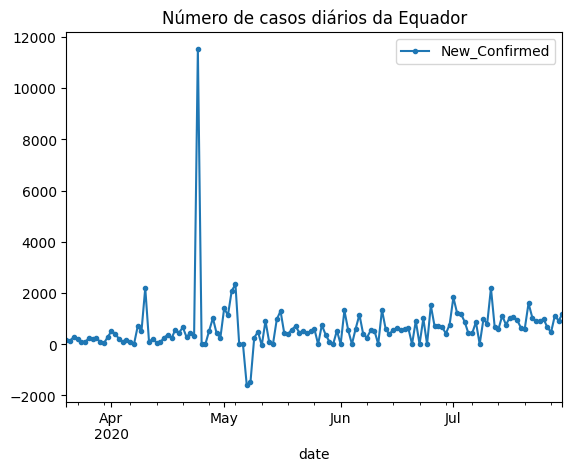

In [9]:
reg_data_ec = read_data('EC')
reg_data_ec = reg_data_ec.loc[reg_data_ec.ge(100).idxmax()[0]:]
reg_data_ec.plot(marker='.')
plt.title('Número de casos diários da Equador');

In [10]:
anomaly = reg_data_ec.query('New_Confirmed > 10_000').index
previous_dates = [anomaly.values[:][0] - np.timedelta64(i, 'D') for i in range(1, 8)]
previous_values = reg_data_ec.loc[previous_dates]
mean_previous = previous_values.mean()
reg_data_ec.loc[anomaly] = mean_previous
reg_data_ec.fillna(mean_previous, inplace=True)


In [11]:
negatives = reg_data_ec.query('New_Confirmed < 0').index
reg_data_ec.loc[negatives] = 0

2020-04-07 00:00:00
2020-04-25 00:00:00
2020-04-26 00:00:00
2020-05-05 00:00:00
2020-05-06 00:00:00
2020-05-07 00:00:00
2020-05-08 00:00:00
2020-05-11 00:00:00
2020-05-26 00:00:00
2020-05-30 00:00:00
2020-06-01 00:00:00
2020-06-04 00:00:00
2020-06-11 00:00:00
2020-06-20 00:00:00
2020-06-22 00:00:00
2020-06-24 00:00:00
2020-07-08 00:00:00


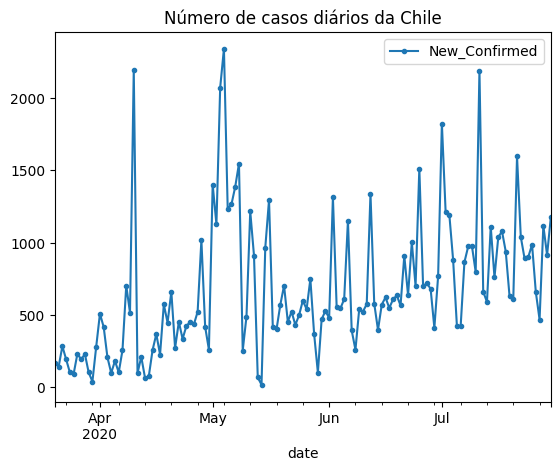

In [12]:
anomaly = reg_data_ec.query('New_Confirmed == 0').index
for index in anomaly:
    print(index)
    previous_dates = [index - np.timedelta64(i, 'D') for i in range(1, 8)]
    previous_values = reg_data_ec.loc[previous_dates]
    mean_previous = previous_values.mean()
    reg_data_ec.loc[index] = mean_previous
    reg_data_ec.fillna(mean_previous, inplace=True)

reg_data_ec.plot(marker='.')
plt.title('Número de casos diários da Chile');

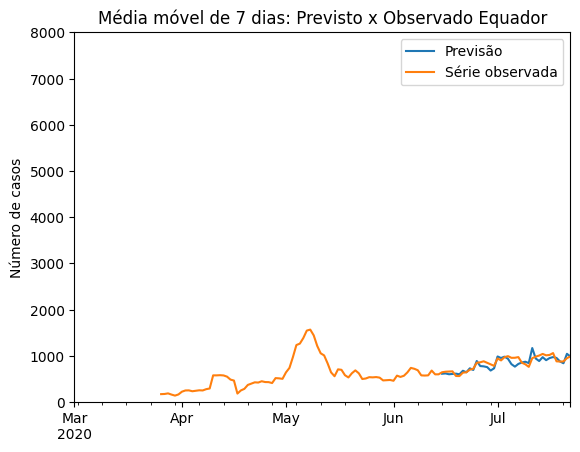

In [13]:
train_data = reg_data_ec.iloc[:88]
test_data = reg_data_ec.iloc[88:]
fcst_eq = arima_model(train_data, test_data, p=1, d=1, q=1,
                      model_name='ARIMA', 
                      country='Equador', 
                      horizon=7, y_lim=8_000,
                      country_plot='Equador')


In [14]:
metricas_eq = avalia_previsoes(fcst_eq, test_data)
# metricas_eq.to_csv('../../avaliavao_aequador.csv', index=False)

  horizonte        r²        RMSE         MAE      MAPE    Correl
0        h1 -0.166868  409.302422  274.879404  0.308645  0.096763
1        h2 -0.167460  406.675266  270.738969  0.308904  0.022990
2        h3 -0.158714  400.720203  259.619594  0.288899  0.039624
3        h4 -0.189927  405.002749  268.502949  0.302791 -0.002482
4        h5 -0.161667  404.661111  267.102663  0.301176  0.022515
5        h6 -0.084417  388.191782  259.085926  0.284043  0.155999
6        h7 -0.053433  382.603727  258.745471  0.278161  0.198520
7    7 dias -2.151132  168.409737  143.255215  0.158145  0.274549
